# ARC AGI with Llama 3.2 1B - Test-time Fine-tuning

## 1. Add Datasets and Model

We will be using the following datasets:

1. ‘Abstraction and Reasoning Challenge’: This is the official dataset containing the ARC tasks to be solved.
1. (Optional) ‘Llama-3-ARC-deps’: This dataset contains the wheel files for additional packages not available in the Kaggle Kernel. Note that this dataset is required if you plan to submit this notebook to the competition, as no internet access is allowed during the competition. You can find it [here](https://www.kaggle.com/datasets/hansuelijud/llama-3-arc-deps).

Please note that to access the Llama 3 model on Kaggle, you need to obtain access from Meta. Instructions on how to do this can be found [here](https://www.kaggle.com/models/metaresearch/llama-3).

## 2. Install and import Packages
For competition submissions, since internet access is restricted, we will use a Kaggle dataset containing the required wheel files. This allows us to install the packages without needing internet access during the submission process.

### 2.1 With internet access:

If we have internet access we can just directly install the packages:

In [4]:
!python -m pip install --upgrade pip -q
!pip install pandas datasets tensorboard matplotlib -qU

In [1]:
# !pip install vllm -qU
# import vllm
# # print(vllm.__file__)  # This will give you the path to the installed vllm package
# # !pip show vllm

In [2]:
# os.environ["VLLM_WORKER_MULTIPROC_METHOD"] = "spawn" # for using multiple GPUs

### 2.2 Without internet access (use for submission):

If we don't have internet access you can:
1. Add the dataset we prepared [llama-3-arc-deps](https://www.kaggle.com/datasets/hansuelijud/llama-3-arc-deps).
2. Create your own dataset. You can find the explanation [here](https://www.kaggle.com/code/hansuelijud/llama-3-8b-arc-additional-dependencies).

In [3]:
# deps_path = '/kaggle/input/llama-3-arc-deps'
# ! pip install --no-index --find-links {deps_path} --requirement {deps_path}/requirements.txt

### 2.3 Import Packages

Now, let’s import the necessary packages:

In [4]:
# For dataset
import pandas as pd
import json
import os
import ast
import re
import numpy as np
from datasets import Dataset

import torch
from time import time

## 3. Load the data

Next, let’s load the ARC tasks. Note that we will split tasks containing more than one test input into separate tasks, as this makes the pipeline easier. In the end, we will combine them again to create a valid submission file.

In [5]:
# Function to split the tasks that have multiple test input/output pairs.
# This makes the handling easier, we will combine it again at the end for the submission
def split_dictionary(data):
    """
    Splits the tasks that have multiple test input/output pairs into separate entries.

    Args:
    data (dict): The original dictionary containing tasks with 'test' and 'train' fields.

    Returns:
    tuple: A tuple containing:
        - result (dict): The dictionary with tasks split into separate entries if they have multiple test pairs.
        - split_files (list): A list of keys for the tasks that were split.
    """
    result = {}
    split_files = []
    for key, value in data.items():
        test_list = value.get("test", [])
        train_list = value.get("train", [])
        if len(test_list) > 1:
            for idx, test_item in enumerate(test_list):
                new_key = f"{key}_{idx}"
                result[new_key] = {
                    "test": [test_item],
                    "train": train_list
                }
                split_files.append(new_key)
        else:
            result[key] = value
    return result, split_files

In [6]:
train_run = False # If true, will use training data, False will use evaluation dataset.
test_run = True # Set test_run variable: False: create submission file for private test set, True: Evaluate on public tasks
kaggle = False
print_errors = False

# Prepare data for DataFrame

if kaggle == True:
    # Load JSON data from the files in Kaggle
    if test_run:
        with open('/kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json') as f:
            challenges = json.load(f)
            # Split tasks with multiple test inputs
            challenges, split_files = split_dictionary(challenges) 
    
        with open('/kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json') as f:
            solutions = json.load(f)
    else:
        with open('/kaggle/input/arc-prize-2024/arc-agi_test_challenges.json') as f:
            challenges = json.load(f)
        # Split tasks with multiple test inputs
        challenges, split_files = split_dictionary(challenges)
else:

    if train_run:
        with open('arc-agi_training_challenges.json') as f:
            challenges = json.load(f)
            # Split tasks with multiple test inputs
            challenges, split_files = split_dictionary(challenges) 
    
        with open('arc-agi_training_solutions.json') as f:
            solutions = json.load(f)
    else:
        # Load JSON data from the files in Kaggle
        if test_run:
            with open('arc-agi_evaluation_challenges.json') as f:
                challenges = json.load(f)
                # Split tasks with multiple test inputs
                challenges, split_files = split_dictionary(challenges) 
        
            with open('arc-agi_evaluation_solutions.json') as f:
                solutions = json.load(f)
        else:
            with open('arc-agi_test_challenges.json') as f:
                challenges = json.load(f)
            # Split tasks with multiple test inputs
            challenges, split_files = split_dictionary(challenges) 

# Print how many files have been split and their names
split_file_count = len(split_files)//2

print(f"Number of files split: {split_file_count}")
if False:
    print("File names:")
    for name in split_files:
        print(name)

# Prepare data
data = []
        
for file_name, grids in challenges.items():
    train_grids = grids.get('train', [])
    test_inputs = grids.get('test', [])
    if test_run:
        # Handle files with multiple test inputs
        parts = file_name.split('_')
        if len(parts) > 1:
            test_nr = int(parts[1])
        else:
            test_nr = 0
        test_outputs = solutions.get(parts[0], [])
        # Transform test grids to lists of dicts with 'output' key
        test_outputs_transformed = [{'output': test_outputs[test_nr]}]
        # Combine test inputs and outputs in alternating manner
        combined_tests = [{'input': test_inputs[0]['input'], 'output': test_outputs_transformed[0]['output']}]
    data.append({
            'file_name': file_name,
            'train': train_grids,
            'test_input': test_inputs,
            'test_output': test_outputs_transformed if test_run else [[0, 0]],
            'test': combined_tests if test_run else test_inputs
    })

# Create DataFrame
df = pd.DataFrame(data)

if False:
    # Display the DataFrame
    print(df)

Number of files split: 19


In [7]:
import json

# Load the mit-split.json file
# with open('mit-split.json') as f:
with open('mit-easy.json') as f:
    mit_split_ids = json.load(f)

In [8]:
# Ensure no leading/trailing spaces in mit-split.json
mit_split_ids = [file_name.strip() for file_name in mit_split_ids]

# Ensure no leading/trailing spaces in df['file_name'] and case normalization
df['file_name'] = df['file_name'].str.strip()

# Filter the DataFrame to include all split versions of mit_split_ids
filtered_df = df[df['file_name'].str.extract(r'^([a-f0-9]+)')[0].isin(mit_split_ids)]

# Debugging output: Check for missing files and potential matches
missing_files = [file_name for file_name in mit_split_ids if file_name not in filtered_df['file_name'].str.extract(r'^([a-f0-9]+)')[0].unique()]
if missing_files:
    print(f"Number of missing file names: {len(missing_files)}")
    print("Missing file names:")
    for file_name in missing_files:
        print(file_name)
        # Check if split versions exist in the DataFrame
        potential_matches = df['file_name'][df['file_name'].str.contains(file_name, case=False, na=False)]
        if not potential_matches.empty:
            print(f"Potential matches in DataFrame for {file_name}:")
            print(potential_matches.tolist())
else:
    print("All file names from mit-split.json are present in the DataFrame.")

# Final summary
print(f"Filtered DataFrame has {len(filtered_df)} rows.")
if False:
    print(filtered_df)

All file names from mit-split.json are present in the DataFrame.
Filtered DataFrame has 20 rows.


In [9]:
# Convert the loaded data to a Huggingface Dataset object
dataset = Dataset.from_pandas(filtered_df)

print(dataset)
# print(dataset["file_name"])
# print(dataset["test"][0])
print(f"dataset length = {len(dataset)} entries, after splitting entries with multiple tests")

Dataset({
    features: ['file_name', 'train', 'test_input', 'test_output', 'test', '__index_level_0__'],
    num_rows: 20
})
dataset length = 20 entries, after splitting entries with multiple tests


In [10]:
print(dataset[0])

{'file_name': '00576224', 'train': [{'input': [[8, 6], [6, 4]], 'output': [[8, 6, 8, 6, 8, 6], [6, 4, 6, 4, 6, 4], [6, 8, 6, 8, 6, 8], [4, 6, 4, 6, 4, 6], [8, 6, 8, 6, 8, 6], [6, 4, 6, 4, 6, 4]]}, {'input': [[7, 9], [4, 3]], 'output': [[7, 9, 7, 9, 7, 9], [4, 3, 4, 3, 4, 3], [9, 7, 9, 7, 9, 7], [3, 4, 3, 4, 3, 4], [7, 9, 7, 9, 7, 9], [4, 3, 4, 3, 4, 3]]}], 'test_input': [{'input': [[3, 2], [7, 8]]}], 'test_output': [{'output': [[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, 3, 2, 3, 2, 3], [8, 7, 8, 7, 8, 7], [3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8]]}], 'test': [{'input': [[3, 2], [7, 8]], 'output': [[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, 3, 2, 3, 2, 3], [8, 7, 8, 7, 8, 7], [3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8]]}], '__index_level_0__': 0}


In [11]:
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np

def plot_grid(grid, title=''):
    """Plots a grid using the specified color map."""
    color_map = {0: '#000000', 1: '#0000FF', 2: '#FF0000', 3: '#00FF00', 4: '#FFFF00', 5: '#808080', 6: '#FF00FF', 7: '#FFA500', 8: '#008080', 9: '#A52A2A'}
    grid_array = np.array(grid)
    plt.imshow(grid_array, vmin=0, vmax=9, interpolation='nearest', cmap=matplotlib.colors.ListedColormap(list(color_map.values()))) # Use colormap
    plt.title(title)
    n_rows, n_cols = grid_array.shape
    for i in range(n_rows):
        for j in range(n_cols):
            plt.text(j, i, str(grid_array[i, j]), ha='center', va='center', color='white') # Set text color to white
    plt.show()

Selecting inner index 0


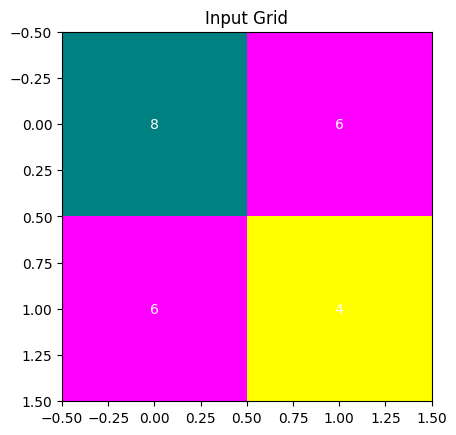

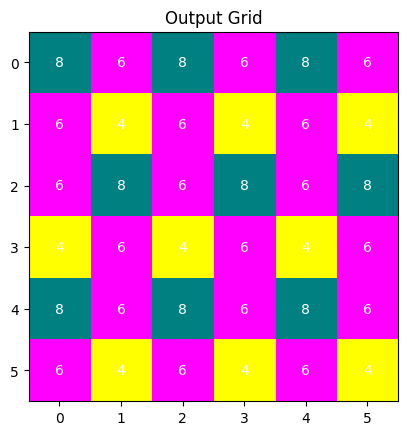

In [12]:
challenge_index = 0
challenge_split='train' # train or test
split_index=0
type='input' # input or output

challenge = dataset[challenge_index]
print(f"Selecting inner index {split_index}")

challenge_split = challenge[challenge_split]
plot_grid(challenge_split[split_index]['input'], 'Input Grid')
plot_grid(challenge_split[split_index]['output'], 'Output Grid')

grid = challenge_split[split_index][type]

## 4. Create Test-time Dataset
- Take the train examples from a given dataset (starting with the filtered dataset).
- Create a hf style dataset of messages, with a user message containing the first n-1 of n examples (inputs plus outputs) as train examples and the nth train input as the test example, and with an assistant message using the nth train output.

Later:
(- Expand that dataset via shuffling.)
(- Expand that dataset via colours.)
(- Expand that dataset via rotations.)

In [309]:
from datasets import Dataset
import numpy as np

def prepare_evaluation_dataset(input_dataset, drop_first_train=True):
    """
    Prepares evaluation datasets from the input dataset.
    
    Args:
        input_dataset: A dataset containing 'file_name', 'train', and 'test' splits.
                       Each 'train' entry contains 'input' and 'output' examples, and
                       'test' contains 'input' and 'output' for evaluation.
        drop_first_train (bool): Whether to drop the first training example. Defaults to True.
    
    Returns:
        - evaluation_dataset: Dataset formatted for evaluation.
    """
    
    # Evaluation dataset preparation
    evaluation_data = []
    for challenge in input_dataset:
        file_name = challenge['file_name']
        train_examples = challenge['train']
        test_example = challenge['test'][0]  # Use the first test example
        
        # Use all training examples as context, optionally dropping the first one
        start_index = 1 if drop_first_train else 0
        user_message_content = (
            "Given the following training examples with their input-output pairs, "
            "predict the output for the test input based on the same transformation rules:\n\n"
        )
        for i, example in enumerate(train_examples[start_index:]):  # Include all training examples
            user_message_content += (
                f"Input:\n{np.array(example['input'])}\n"
                f"Output:\n{np.array(example['output'])}\n\n"
            )
        # Use the first test example's input as the test input
        test_input = test_example['input']
        user_message_content += f"Test Input:\n{np.array(test_input)}\nTest Output:\n"
        user_message = {"role": "user", "content": user_message_content}
        assistant_message = {
            "role": "assistant",
            "content": f"{np.array(test_example['output'])}\n\n"
        }

        evaluation_data.append({
            "file_name": file_name,
            "messages": [user_message, assistant_message]
        })
    
    # Create HuggingFace Datasets
    evaluation_dataset = Dataset.from_list(evaluation_data)
    
    return evaluation_dataset

In [310]:
def prepare_fine_tuning_dataset(input_dataset, add_shuffled=True, apply_color_swaps=False, 
                                add_rotations=False, add_mirrors=False, seed=42):
    """
    Expands the fine-tuning dataset by generating rows for each challenge.
    Includes optional shuffling, color swaps, rotations, and mirroring data augmentations.
    
    Args:
        input_dataset: A dataset containing 'file_name' and 'train' splits.
                       Each 'train' entry contains 'input' and 'output' examples.
        add_shuffled (bool): Whether to generate multiple rows with shuffled context examples.
        apply_color_swaps (bool): Whether to apply color-swapping data augmentation.
        add_rotations (bool): Whether to add rotated examples (90°, 180°, 270°).
        add_mirrors (bool): Whether to add mirrored examples (horizontal, vertical).
        seed (int): Seed for reproducibility in shuffling and color swapping.
    
    Returns:
        A HuggingFace Dataset with expanded rows.
    """
    np.random.seed(seed)
    expanded_data = []

    def rotate_grid(grid, angle):
        """Rotates a grid 90°, 180°, or 270°."""
        grid_np = np.array(grid)
        if angle == 90:
            return np.rot90(grid_np, k=1).tolist()
        elif angle == 180:
            return np.rot90(grid_np, k=2).tolist()
        elif angle == 270:
            return np.rot90(grid_np, k=3).tolist()
        return grid  # Default is no rotation

    def mirror_grid(grid, direction):
        """Mirrors a grid horizontally or vertically."""
        grid_np = np.array(grid)
        if direction == "horizontal":
            return np.fliplr(grid_np).tolist()
        elif direction == "vertical":
            return np.flipud(grid_np).tolist()
        return grid  # Default is no mirroring

    def generate_rows_with_augmentation(train_examples, file_name, rotation_angles=None, mirror_directions=None):
        """
        Generates new rows for augmented examples.
        """
        rows = []
        for example in train_examples:
            # Original example
            rows.append({
                "file_name": file_name,
                "messages": [
                    {"role": "user", "content": f"Input:\n{example['input']}\nOutput:\n{example['output']}"},
                    {"role": "assistant", "content": f"{example['output']}"}
                ]
            })
            # Rotated examples
            if rotation_angles:
                for angle in rotation_angles:
                    rotated_input = rotate_grid(example["input"], angle)
                    rotated_output = rotate_grid(example["output"], angle)
                    rows.append({
                        "file_name": file_name,
                        "messages": [
                            {"role": "user", "content": f"Input:\n{rotated_input}\nOutput:\n{rotated_output}"},
                            {"role": "assistant", "content": f"{rotated_output}"}
                        ]
                    })
            # Mirrored examples
            if mirror_directions:
                for direction in mirror_directions:
                    mirrored_input = mirror_grid(example["input"], direction)
                    mirrored_output = mirror_grid(example["output"], direction)
                    rows.append({
                        "file_name": file_name,
                        "messages": [
                            {"role": "user", "content": f"Input:\n{mirrored_input}\nOutput:\n{mirrored_output}"},
                            {"role": "assistant", "content": f"{mirrored_output}"}
                        ]
                    })
        return rows

    # Generate the initial dataset and augment it
    for challenge in input_dataset:
        file_name = challenge['file_name']
        train_examples = challenge['train']

        # Augment with rotations and mirroring
        augmented_rows = generate_rows_with_augmentation(
            train_examples,
            file_name,
            rotation_angles=[90, 180, 270] if add_rotations else None,
            mirror_directions=["horizontal", "vertical"] if add_mirrors else None
        )
        expanded_data.extend(augmented_rows)

        if add_shuffled:
            # Add shuffled variations for each example
            for i in range(len(train_examples)):
                test_input = train_examples[i]['input']
                test_output = train_examples[i]['output']
                remaining_examples = train_examples[:i] + train_examples[i+1:]
                context_examples = np.random.permutation(remaining_examples).tolist()

                user_message_content = (
                    "Given the following training examples with their input-output pairs, "
                    "predict the output for the test input based on the same transformation rules:\n\n"
                )
                for example in context_examples:
                    user_message_content += (
                        f"Input:\n{np.array(example['input'])}\n"
                        f"Output:\n{np.array(example['output'])}\n\n"
                    )
                user_message_content += f"Test Input:\n{np.array(test_input)}\nTest Output:\n"
                user_message = {"role": "user", "content": user_message_content}
                assistant_message = {"role": "assistant", "content": f"{np.array(test_output)}\n\n"}

                expanded_data.append({
                    "file_name": file_name,
                    "messages": [user_message, assistant_message]
                })

    # Apply color swaps if required
    if apply_color_swaps:
        swapped_data = []
        for row in expanded_data:
            swapped_data.extend(swap_colors(row))
        expanded_data.extend(swapped_data)

    # Create HuggingFace Dataset
    fine_tuning_dataset = Dataset.from_list(expanded_data)
    return fine_tuning_dataset


In [311]:
print(dataset.select(range(1)))

Dataset({
    features: ['file_name', 'train', 'test_input', 'test_output', 'test', '__index_level_0__'],
    num_rows: 1
})


In [312]:
print(dataset[0])

{'file_name': '00576224', 'train': [{'input': [[8, 6], [6, 4]], 'output': [[8, 6, 8, 6, 8, 6], [6, 4, 6, 4, 6, 4], [6, 8, 6, 8, 6, 8], [4, 6, 4, 6, 4, 6], [8, 6, 8, 6, 8, 6], [6, 4, 6, 4, 6, 4]]}, {'input': [[7, 9], [4, 3]], 'output': [[7, 9, 7, 9, 7, 9], [4, 3, 4, 3, 4, 3], [9, 7, 9, 7, 9, 7], [3, 4, 3, 4, 3, 4], [7, 9, 7, 9, 7, 9], [4, 3, 4, 3, 4, 3]]}], 'test_input': [{'input': [[3, 2], [7, 8]]}], 'test_output': [{'output': [[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, 3, 2, 3, 2, 3], [8, 7, 8, 7, 8, 7], [3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8]]}], 'test': [{'input': [[3, 2], [7, 8]], 'output': [[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, 3, 2, 3, 2, 3], [8, 7, 8, 7, 8, 7], [3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8]]}], '__index_level_0__': 0}


In [315]:
fine_tuning_dataset = prepare_fine_tuning_dataset(dataset, add_shuffled=True, apply_color_swaps=False, 
                                add_rotations=True, add_mirrors=True, seed=42)
# fine_tuning_dataset = prepare_fine_tuning_dataset(dataset.select(range(19,20)), shuffle_and_expand=True)
# fine_tuning_dataset = prepare_fine_tuning_dataset(dataset.select([0]), shuffle_and_expand=True)
# fine_tuning_dataset = prepare_fine_tuning_dataset(dataset, add_shuffled=True, apply_color_swaps=False)
# fine_tuning_dataset = prepare_fine_tuning_dataset(dataset.select([0]), add_shuffled=False, apply_color_swaps=True)

In [316]:
print(fine_tuning_dataset)

Dataset({
    features: ['file_name', 'messages'],
    num_rows: 420
})


In [317]:
# print(fine_tuning_dataset[419])

In [318]:
eval_dataset = prepare_evaluation_dataset(dataset, drop_first_train=False)

In [319]:
print(eval_dataset)

Dataset({
    features: ['file_name', 'messages'],
    num_rows: 20
})


In [273]:
print(eval_dataset[19])

{'file_name': 'f3cdc58f', 'messages': [{'content': 'Given the following training examples with their input-output pairs, predict the output for the test input based on the same transformation rules:\n\nInput:\n[[0 0 0 0 0 0 0 0 0 0]\n [0 0 0 0 0 0 0 0 4 0]\n [2 0 0 0 0 3 0 1 4 1]\n [0 0 0 0 0 0 1 0 0 0]\n [1 4 0 0 0 0 0 0 0 1]\n [0 0 0 0 2 0 0 0 2 0]\n [0 0 4 0 0 0 0 0 0 0]\n [1 0 0 4 0 4 0 0 3 0]\n [0 0 0 0 0 0 0 0 0 0]\n [0 1 2 1 0 0 0 0 0 0]]\nOutput:\n[[0 0 0 0 0 0 0 0 0 0]\n [0 0 0 0 0 0 0 0 0 0]\n [1 0 0 0 0 0 0 0 0 0]\n [1 0 0 0 0 0 0 0 0 0]\n [1 0 0 4 0 0 0 0 0 0]\n [1 0 0 4 0 0 0 0 0 0]\n [1 2 0 4 0 0 0 0 0 0]\n [1 2 0 4 0 0 0 0 0 0]\n [1 2 3 4 0 0 0 0 0 0]\n [1 2 3 4 0 0 0 0 0 0]]\n\nInput:\n[[0 0 0 0 0 4 0 3 3 0]\n [0 1 3 0 0 0 3 0 0 0]\n [0 0 0 0 1 0 0 1 0 4]\n [3 0 0 0 2 0 0 0 2 0]\n [0 0 0 0 0 0 0 0 0 0]\n [0 0 1 0 0 0 0 0 0 0]\n [0 0 2 0 0 0 0 2 0 0]\n [0 3 0 0 0 4 3 2 0 0]\n [0 0 0 1 0 0 0 0 3 0]\n [0 0 4 0 0 4 0 1 0 1]]\nOutput:\n[[0 0 0 0 0 0 0 0 0 0]\n [0 0 0 0 0 0 0

## 5. Fine-tune with Unsloth
- Load unsloth
- apply lora
- train
- Train on outputs only

Later:
[] Remove the date from the chat template.

In [250]:
%%capture
!pip install unsloth accelerate hf_transfer
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

In [27]:
!pip install flash-attn --no-build-isolation -qU

## RESTART THE KERNEL NOW

In [275]:
!pip show flash-attn

Name: flash-attn
Version: 2.7.0.post2
Summary: Flash Attention: Fast and Memory-Efficient Exact Attention
Home-page: https://github.com/Dao-AILab/flash-attention
Author: Tri Dao
Author-email: tri@tridao.me
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: einops, torch
Required-by: 


In [276]:
# !pip uninstall flash-attn -y

In [346]:
import os
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1" #for fast weight downloads

from unsloth import FastLanguageModel
import torch
max_seq_length = 8000 # 6k needed for easy (if dropping first pair from eval), 8k if not dropping. 20k needed for full MIT split
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = False # Use 4bit quantization to reduce memory usage. Can be False.

# del model, tokenizer

model_slug = 'unsloth/Llama-3.2-1B'
# model_slug = 'unsloth/Llama-3.2-3B'
# model_slug = 'unsloth/Llama-3.2-1B-Instruct'
# model_slug = 'unsloth/Llama-3.2-3B-Instruct'
# model_slug = "Qwen/Qwen2.5-Math-1.5B"
# model_slug = "Qwen/Qwen2.5-1.5B"
# model_slug = "Qwen/Qwen2.5-Coder-1.5B"

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_slug,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [347]:
# Define the Jinja template
tokenizer.chat_template = """
{% for message in messages %}
{{ message.content }}{% if message.role == 'assistant' %}{{ eos_token }}{% endif %}{%- if add_generation_prompt %}{%- endif %}
{% endfor %}
"""

In [348]:
print(eval_dataset[0]['messages'])

[{'content': 'Given the following training examples with their input-output pairs, predict the output for the test input based on the same transformation rules:\n\nInput:\n[[8 6]\n [6 4]]\nOutput:\n[[8 6 8 6 8 6]\n [6 4 6 4 6 4]\n [6 8 6 8 6 8]\n [4 6 4 6 4 6]\n [8 6 8 6 8 6]\n [6 4 6 4 6 4]]\n\nInput:\n[[7 9]\n [4 3]]\nOutput:\n[[7 9 7 9 7 9]\n [4 3 4 3 4 3]\n [9 7 9 7 9 7]\n [3 4 3 4 3 4]\n [7 9 7 9 7 9]\n [4 3 4 3 4 3]]\n\nTest Input:\n[[3 2]\n [7 8]]\nTest Output:\n', 'role': 'user'}, {'content': '[[3 2 3 2 3 2]\n [7 8 7 8 7 8]\n [2 3 2 3 2 3]\n [8 7 8 7 8 7]\n [3 2 3 2 3 2]\n [7 8 7 8 7 8]]\n\n', 'role': 'assistant'}]


In [349]:
print(tokenizer.apply_chat_template(eval_dataset[0]['messages'],tokenize=False) )


Given the following training examples with their input-output pairs, predict the output for the test input based on the same transformation rules:

Input:
[[8 6]
 [6 4]]
Output:
[[8 6 8 6 8 6]
 [6 4 6 4 6 4]
 [6 8 6 8 6 8]
 [4 6 4 6 4 6]
 [8 6 8 6 8 6]
 [6 4 6 4 6 4]]

Input:
[[7 9]
 [4 3]]
Output:
[[7 9 7 9 7 9]
 [4 3 4 3 4 3]
 [9 7 9 7 9 7]
 [3 4 3 4 3 4]
 [7 9 7 9 7 9]
 [4 3 4 3 4 3]]

Test Input:
[[3 2]
 [7 8]]
Test Output:
[[3 2 3 2 3 2]
 [7 8 7 8 7 8]
 [2 3 2 3 2 3]
 [8 7 8 7 8 7]
 [3 2 3 2 3 2]
 [7 8 7 8 7 8]]

<|end_of_text|>


In [350]:
def get_longest_row_in_tokens(dataset, tokenizer):
    """
    Calculates the token length of the concatenated 'messages' content for each row
    in the dataset and returns the length of the longest row.

    Args:
        dataset: A dataset with a 'messages' column containing lists of message dicts.
        tokenizer: A tokenizer instance to tokenize the messages.

    Returns:
        int: The length in tokens of the longest row.
    """
    max_length = 0

    for row in dataset:
        # Concatenate all message contents
        concatenated_content = " ".join(msg["content"] for msg in row["messages"])

        # Tokenize the concatenated content and calculate its length
        tokenized_length = len(tokenizer(concatenated_content)["input_ids"])

        # Track the maximum length
        max_length = max(max_length, tokenized_length)

    return max_length

In [351]:
get_longest_row_in_tokens(fine_tuning_dataset, tokenizer)

5586

In [352]:
get_longest_row_in_tokens(eval_dataset, tokenizer)

7448

In [353]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048, padding_idx=128004)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaExtendedRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
 

In [354]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 32, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    # target_modules = ["all-linear"],
    modules_to_save = ["lm_head","embed_tokens"],
    lora_alpha = 32,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = True,  # We support rank stabilized LoRA
)

Unsloth: Offloading input_embeddings to disk to save VRAM


/usr/local/lib/python3.10/dist-packages/unsloth/models/_utils.py:747: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  offloaded_W = torch.load(filename, map_location = "cpu", 

Unsloth: Offloading output_embeddings to disk to save VRAM
Unsloth: Training embed_tokens in mixed precision to save VRAM
Unsloth: Training lm_head in mixed precision to save VRAM


In [356]:
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

gradient_accumulation_steps=1
batch_size=4
epochs=2

def lr_lambda(current_step: int, num_training_steps: int):
    if current_step < num_training_steps // 2:
        return 1.0  # Constant learning rate for the first epoch
    else:
        # Cosine decay for the second epoch
        progress = (current_step - num_training_steps // 2) / (num_training_steps // 2)
        return 0.5 * (1 + torch.cos(torch.tensor(progress * torch.pi)).item())

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)

# Calculate the total training steps
num_training_steps = len(fine_tuning_dataset) * epochs // (batch_size * gradient_accumulation_steps)

# Create the scheduler
scheduler = LambdaLR(optimizer, lr_lambda=lambda step: lr_lambda(step, num_training_steps))

# Pass optimizer and scheduler explicitly to the trainer
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=fine_tuning_dataset,
    eval_dataset=eval_dataset,
    max_seq_length=max_seq_length,
    # data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    dataset_num_proc=2,
    packing=False,
    args=TrainingArguments(
        # group_by_length=False,  # Disable grouping by length (disables shuffling)
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=1,
        gradient_accumulation_steps=gradient_accumulation_steps,
        num_train_epochs=epochs,
        logging_strategy="steps",
        logging_dir="logs",
        eval_strategy="steps",
        eval_steps=0.2,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=0.1,
        optim="adamw_torch",
        seed=3407,
        output_dir="outputs",
        report_to="tensorboard",
    ),
    optimizers=(optimizer, scheduler),  # Pass the custom optimizer and scheduler
)

Map (num_proc=2):   0%|          | 0/420 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/20 [00:00<?, ? examples/s]

In [357]:
# # Requires commenting in the datacollator above in the trainer.
# from unsloth.chat_templates import train_on_responses_only
# trainer = train_on_responses_only(
#     trainer,
#     # instruction_part = "<|start_header_id|>user<|end_header_id|>\n\n",
#     # response_part = "<|start_header_id|>assistant<|end_header_id|>\n\n",
#     instruction_part = "Input:\n",
#     response_part = "Test Output:\n",
# )

# tokenizer.decode(trainer.train_dataset[0]["input_ids"])

# space = tokenizer(" ", add_special_tokens = False).input_ids[0]
# tokenizer.decode([space if x == -100 else x for x in trainer.train_dataset[0]["labels"]])

In [358]:
# Let SFTTrainer handle the training and log the learning rate
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 420 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 4 | Gradient Accumulation steps = 1
\        /    Total batch size = 4 | Total steps = 210
 "-____-"     Number of trainable parameters = 547,880,960


Step,Training Loss,Validation Loss
42,0.150400,0.196990
84,0.114800,0.171953
126,0.127000,0.158383
168,0.099600,0.141470
210,0.091100,0.134849


TrainOutput(global_step=210, training_loss=0.11873388233638946, metrics={'train_runtime': 121.2609, 'train_samples_per_second': 6.927, 'train_steps_per_second': 1.732, 'total_flos': 2.0052296132788224e+16, 'train_loss': 0.11873388233638946, 'epoch': 2.0})

### Save fine-tuned model

In [359]:
# Save lora
lora_model_name = f"{model_slug.split('/')[-1]}-lora-model"
# lora_model_name = "Llama-3.2-3B-Instruct-lora_model"

tokenizer.chat_template = None

model.save_pretrained(lora_model_name) # Local saving
tokenizer.save_pretrained(lora_model_name) # Local saving

('Llama-3.2-1B-lora-model/tokenizer_config.json',
 'Llama-3.2-1B-lora-model/special_tokens_map.json',
 'Llama-3.2-1B-lora-model/tokenizer.json')

In [360]:
# Define the Jinja template
tokenizer.chat_template = """
{% for message in messages %}
{{ message.content }}{% if message.role == 'assistant' %}{{ eos_token }}{% endif %}{%- if add_generation_prompt %}{%- endif %}
{% endfor %}
"""

## 6. Evaluate using fine-tuned model

In [361]:
import re
import numpy as np

def verify_vs_ground_truth(generated_output_text, correct_output, visualize=False):
    """Compares generated and correct outputs, handling diverse formats."""
    try:
        # Preprocess generated output and correct output
        def preprocess_output(output_text):
            # Replace spaces between numbers with commas
            cleaned_text = re.sub(r"(?<=\d)\s+(?=\d)", ",", output_text.strip())
            # Replace newlines and spaces between rows with commas
            cleaned_text = re.sub(r"\]\s*\[", "],[", cleaned_text)
            return cleaned_text

        # Preprocess both generated and correct outputs
        cleaned_generated_output = preprocess_output(generated_output_text)
        cleaned_correct_output = preprocess_output(correct_output)

        # Parse the cleaned outputs into NumPy arrays
        processed_output = np.array(eval(cleaned_generated_output))
        correct_output_array = np.array(eval(cleaned_correct_output))

        if visualize:
            plot_grid(processed_output, 'Generated Output')
            plot_grid(correct_output_array, 'Correct Output')

        # Validate shapes and broadcast if necessary
        if processed_output.shape != correct_output_array.shape:
            try:
                processed_output = np.broadcast_to(processed_output, correct_output_array.shape)
            except ValueError:
                print(f"Shape mismatch: Generated {processed_output.shape} vs Expected {correct_output_array.shape}")
                return False, 0.0, [[0]]

        # Calculate accuracy
        total_pixels = correct_output_array.size
        correct_pixels = np.sum(processed_output == correct_output_array)
        accuracy = (correct_pixels / total_pixels) * 100
        is_correct = correct_pixels == total_pixels

        return is_correct, accuracy, processed_output

    except Exception as e:
        print(f"Error in processing: {e}, Generated Output: {generated_output_text}")
        return False, 0.0, [[0]]


In [362]:
import re
import ast
import numpy as np
from unsloth.chat_templates import get_chat_template

def solve_challenge_unsloth(messages, model, tokenizer, visualize=False):
    """Solves a single ARC challenge using unsloth for inference."""

    # print(messages)
    
    inputs = tokenizer.apply_chat_template(
        messages[:-1],
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt",
    ).to("cuda")

    # prompt = tokenizer.apply_chat_template(
    #     messages[:-1],
    #     tokenize=False,
    #     add_generation_prompt=True,
    #     return_tensors="pt",
    # )

    # print(prompt)
    
    try:
        # Enable faster inference
        FastLanguageModel.for_inference(model)
        
        outputs = model.generate(input_ids = inputs,
                                 max_new_tokens = 1500, # 1,500 for MIT easy.
                                 use_cache = True,
                                 temperature = 0.01)

        generated_output = outputs[:, inputs.shape[1]:]

        # Decode the output
        generated_output_text = tokenizer.batch_decode(generated_output, skip_special_tokens=True)[0]

        # print(f"Generated output text:\n{generated_output_text}")

        # print(f"Ground Truth:\n{messages[-1]['content']}")
        
        # Verify the generated output
        is_correct, accuracy, processed_output = verify_vs_ground_truth(
            generated_output_text, messages[-1]['content'], visualize=visualize
        )
        
        return {
            'file_name': challenge['file_name'],
            'generated_output': generated_output_text,
            'is_correct': is_correct,
            'accuracy': accuracy,
            'processed_output': processed_output,
        }
    except Exception as e:
        print(f"Error processing challenge {challenge['file_name']}: {e}")
        return {
            'file_name': challenge['file_name'],
            'generated_output': "Error",
            'is_correct': False,
            'accuracy': 0.0,
            'processed_output': [[0]],
        }

In [363]:
print(eval_dataset)

Dataset({
    features: ['file_name', 'messages'],
    num_rows: 20
})


Dataset({
    features: ['file_name', 'messages'],
    num_rows: 20
})


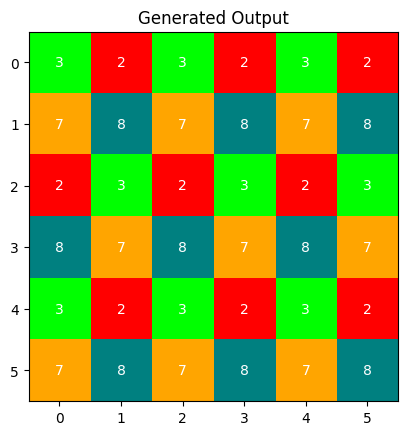

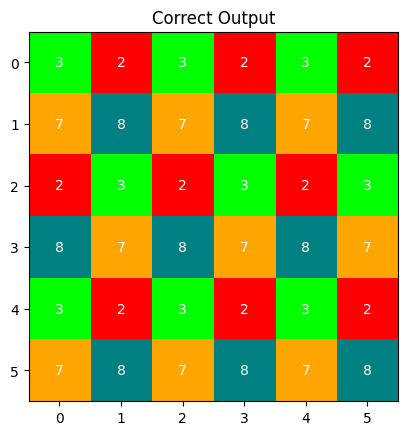

Challenge 1/20 complete. Correct so far: 1/1.


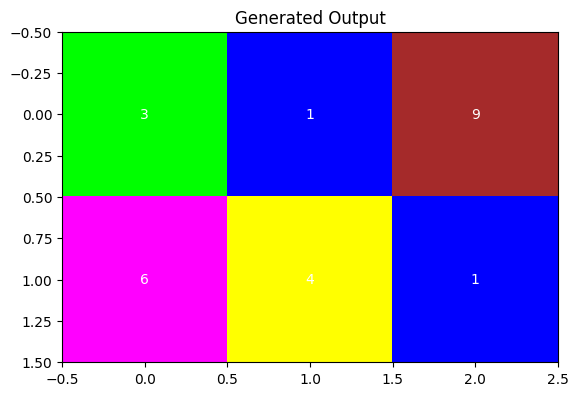

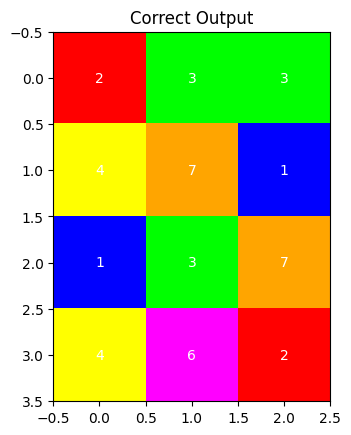

Shape mismatch: Generated (2, 3) vs Expected (4, 3)
Challenge 2/20 complete. Correct so far: 1/2.


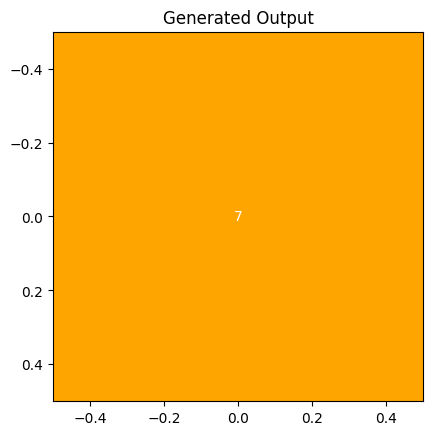

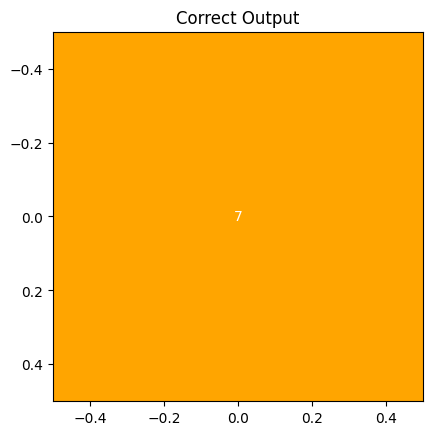

Challenge 3/20 complete. Correct so far: 2/3.


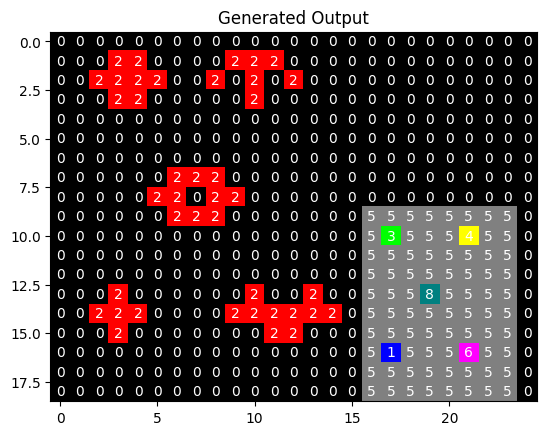

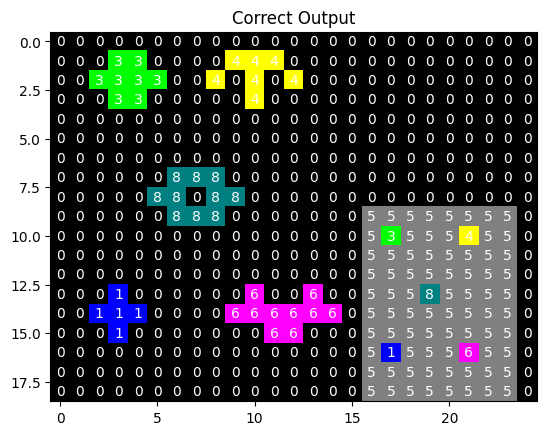

Challenge 4/20 complete. Correct so far: 2/4.


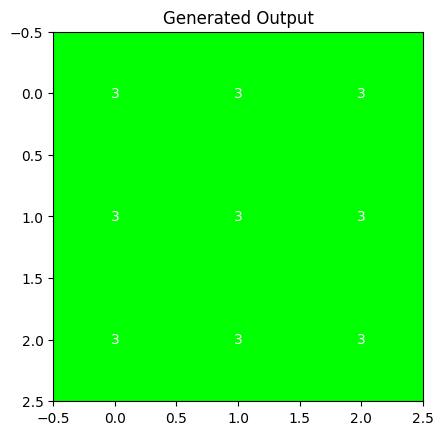

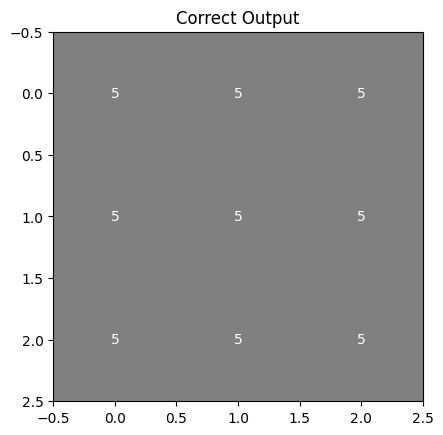

Challenge 5/20 complete. Correct so far: 2/5.


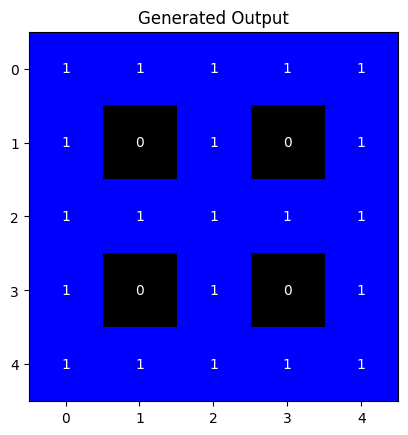

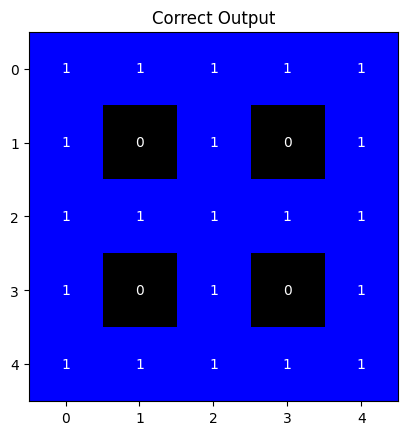

Challenge 6/20 complete. Correct so far: 3/6.


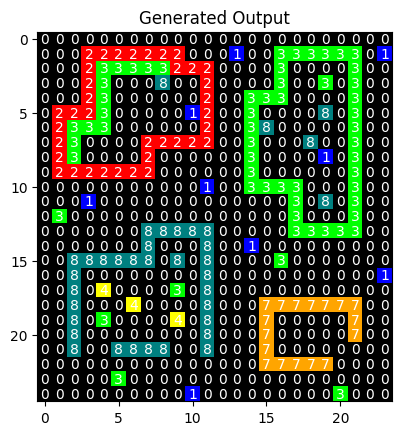

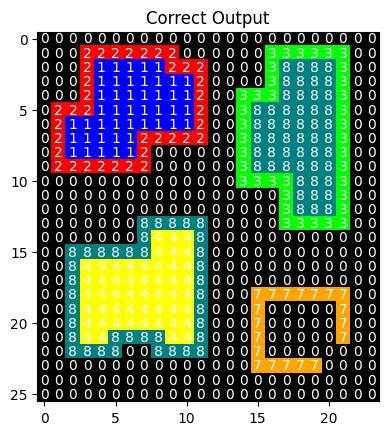

Shape mismatch: Generated (25, 24) vs Expected (26, 24)
Challenge 7/20 complete. Correct so far: 3/7.


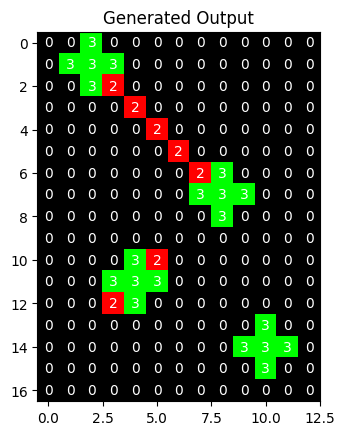

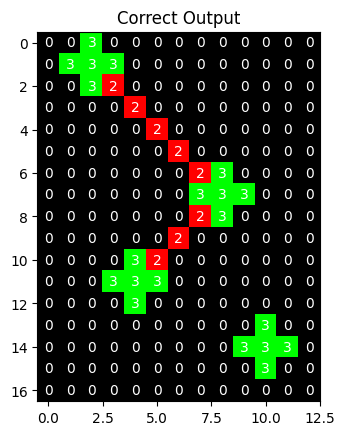

Challenge 8/20 complete. Correct so far: 3/8.


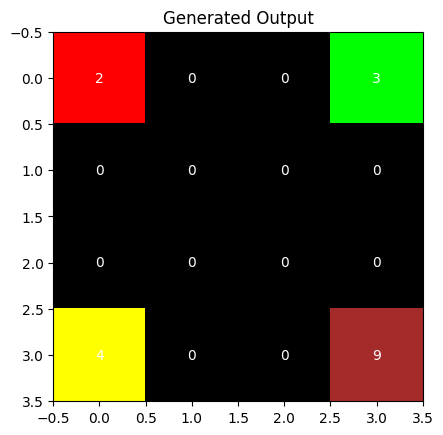

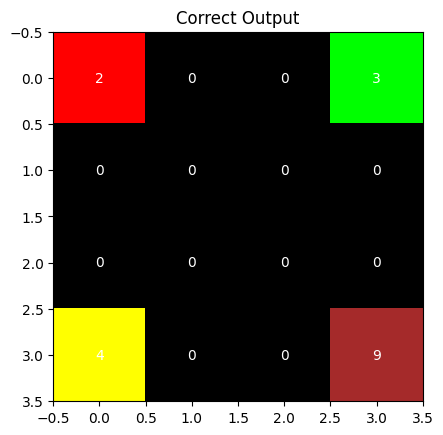

Challenge 9/20 complete. Correct so far: 4/9.


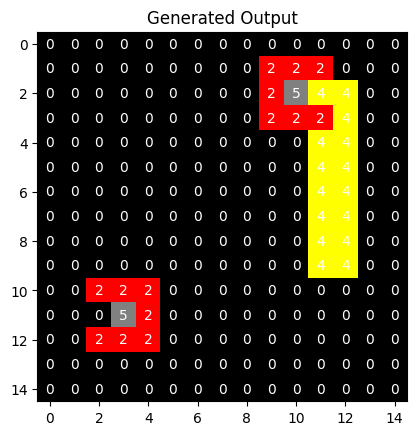

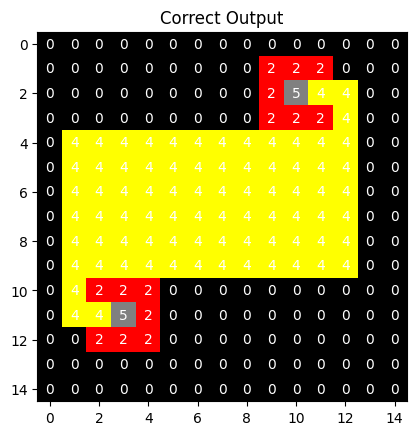

Challenge 10/20 complete. Correct so far: 4/10.


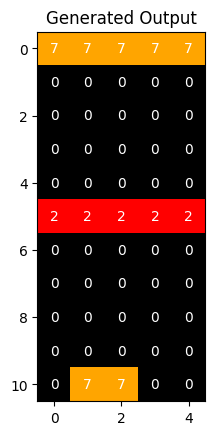

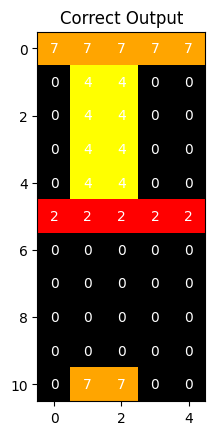

Challenge 11/20 complete. Correct so far: 4/11.


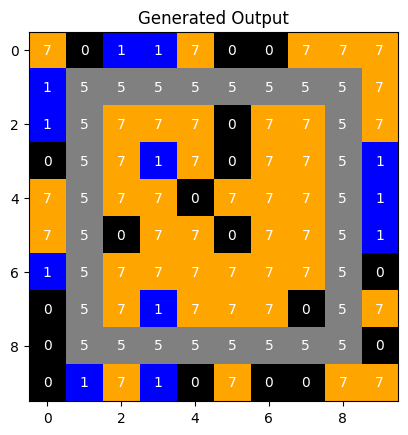

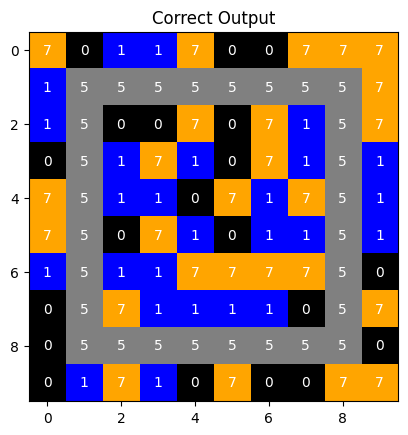

Challenge 12/20 complete. Correct so far: 4/12.


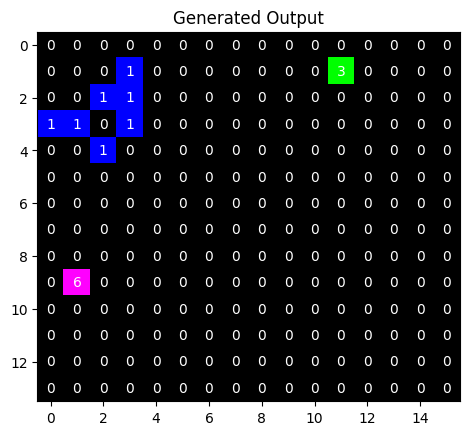

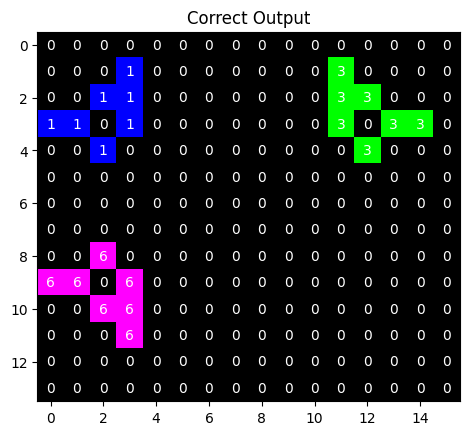

Challenge 13/20 complete. Correct so far: 4/13.


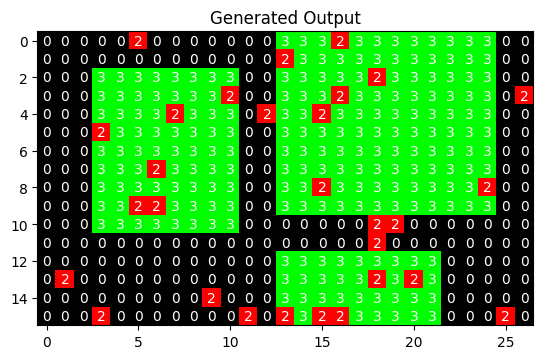

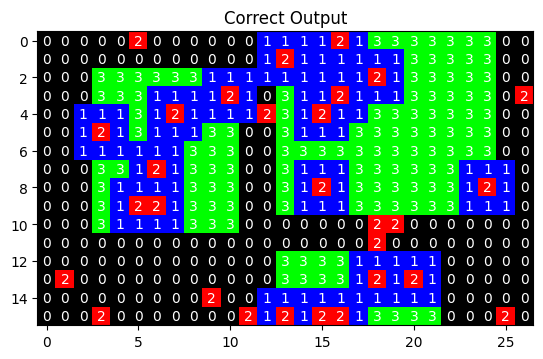

Challenge 14/20 complete. Correct so far: 4/14.


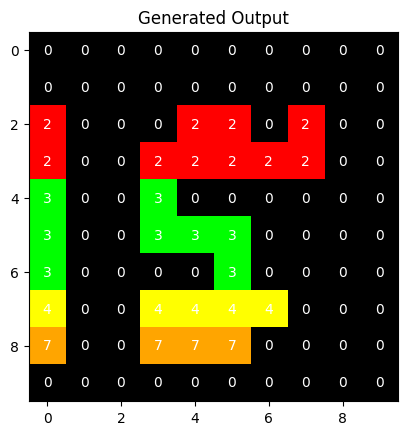

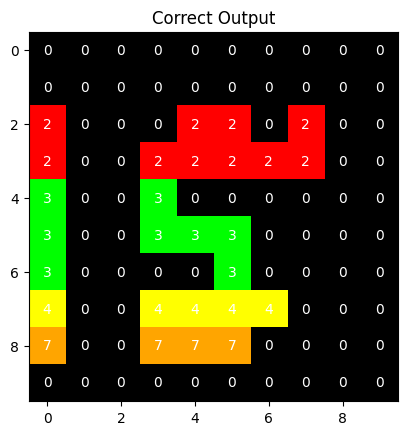

Challenge 15/20 complete. Correct so far: 5/15.


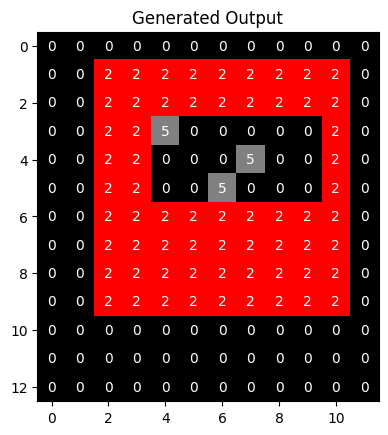

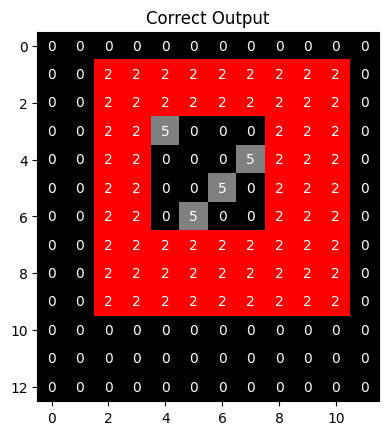

Challenge 16/20 complete. Correct so far: 5/16.


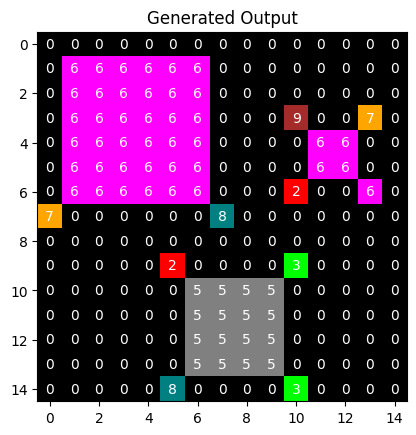

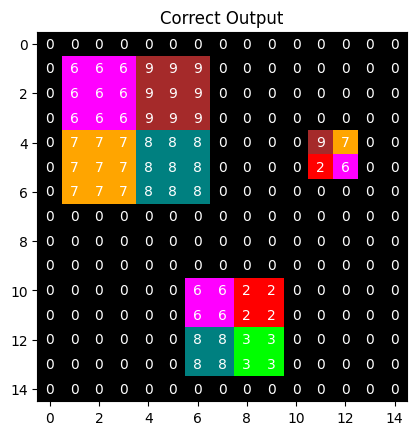

Challenge 17/20 complete. Correct so far: 5/17.


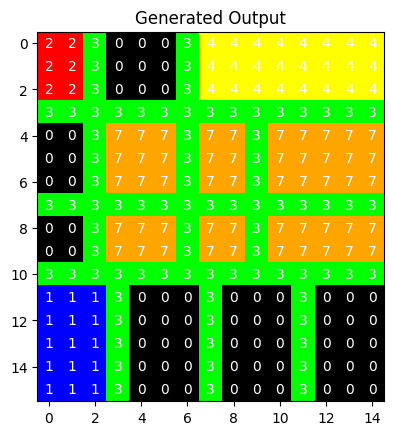

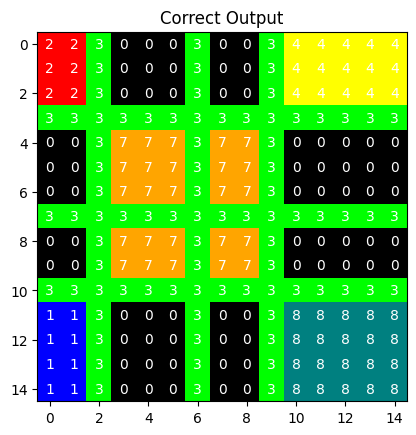

Shape mismatch: Generated (16, 15) vs Expected (15, 15)
Challenge 18/20 complete. Correct so far: 5/18.


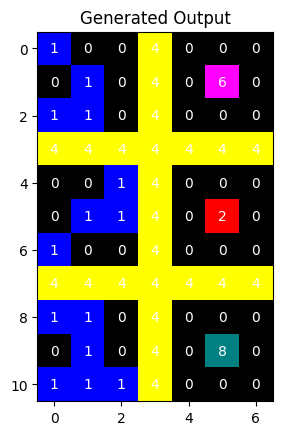

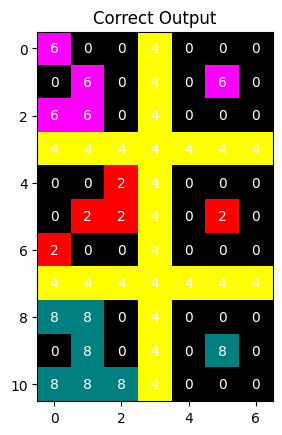

Challenge 19/20 complete. Correct so far: 5/19.


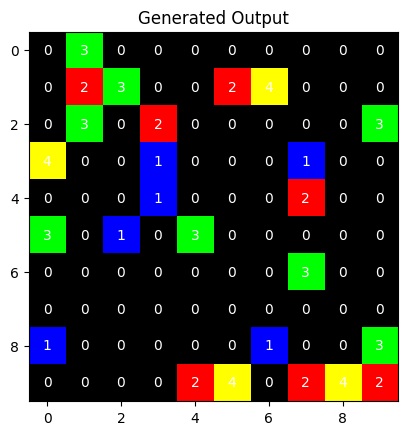

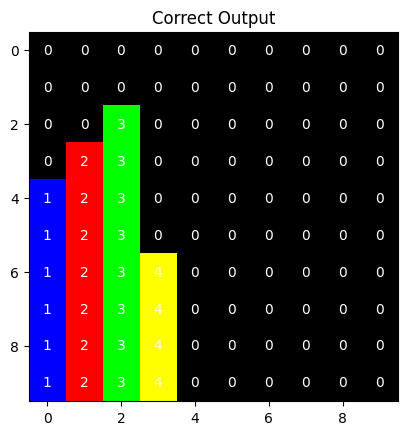

Challenge 20/20 complete. Correct so far: 5/20.
Final Tally: 5/20 challenges correct.


In [364]:
num_tests = 20

dataset_to_run = eval_dataset.select(
    # range(num_tests-3,num_tests)
    range(num_tests)
)

print(dataset_to_run)

results = []
correct_count = 0

for i, challenge in enumerate(dataset_to_run):  # Iterate directly through the dataset
    result = solve_challenge_unsloth(challenge['messages'], model, tokenizer, visualize=True)
    results.append(result)

    # Update the correct count if the result is correct
    if result.get('is_correct', False):
        correct_count += 1

    print(f"Challenge {i+1}/{len(dataset_to_run)} complete. Correct so far: {correct_count}/{i+1}.")

# Final tally
print(f"Final Tally: {correct_count}/{len(dataset_to_run)} challenges correct.")

## 7. Challenge-specific fine-tuning

In [365]:
def filter_fine_tuning_dataset(fine_tuning_dataset, target_file_name):
    """
    Filters the fine-tuning dataset to include only rows corresponding to the specified file name.

    Args:
        fine_tuning_dataset: A HuggingFace Dataset containing expanded fine-tuning data.
        target_file_name: A string specifying the file name to filter by.

    Returns:
        A HuggingFace Dataset containing rows only for the specified file name.
    """
    # Filter the dataset using a list comprehension
    filtered_data = [
        example for example in fine_tuning_dataset 
        if example['file_name'] == target_file_name
    ]
    
    # Create a HuggingFace Dataset from the filtered data
    filtered_dataset = Dataset.from_list(filtered_data)
    
    return filtered_dataset

==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 28


Map (num_proc=2):   0%|          | 0/14 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 14 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 28
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
6,0.109600,0.290160
12,0.075300,0.159205
18,0.051700,0.113243
24,0.029100,0.146714


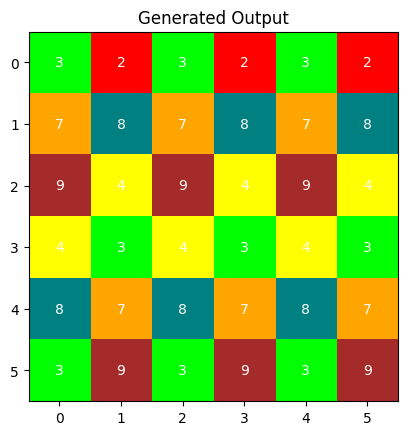

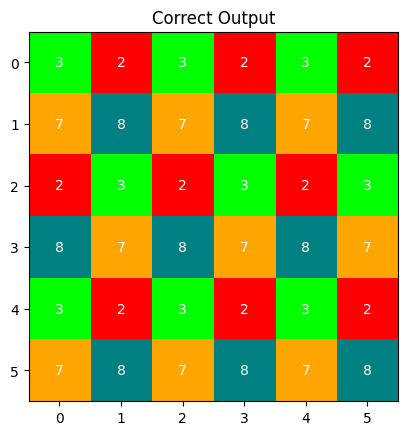

Challenge 1/20 complete. Correct so far: 0/1.
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 42


Map (num_proc=2):   0%|          | 0/21 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 21 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 42
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
9,0.335000,0.444717
18,0.337600,0.431980
27,0.289200,0.417515
36,0.316000,0.399883


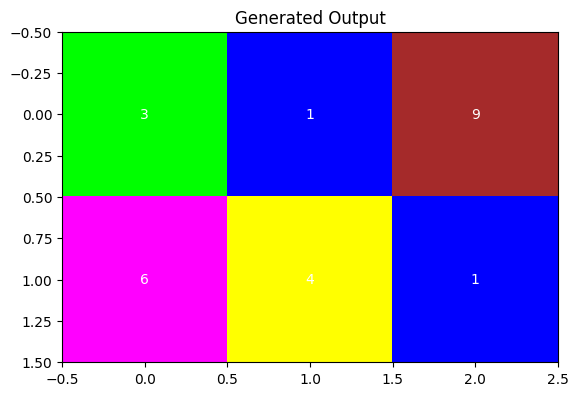

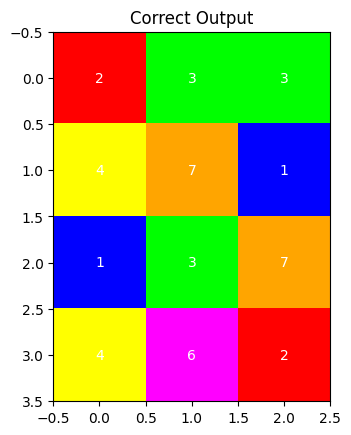

Shape mismatch: Generated (2, 3) vs Expected (4, 3)
Challenge 2/20 complete. Correct so far: 0/2.
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 70


Map (num_proc=2):   0%|          | 0/35 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 35 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 70
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
14,0.104700,0.094664
28,0.083600,0.094137
42,0.056800,0.117382
56,0.046800,0.066559
70,0.037700,0.064267


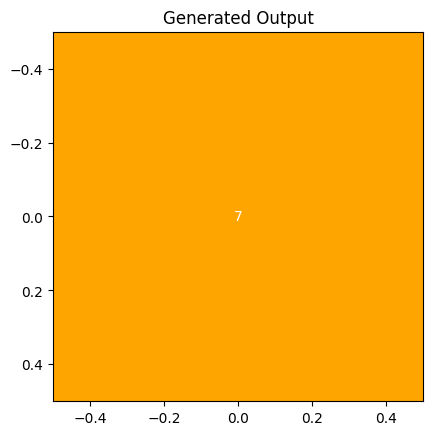

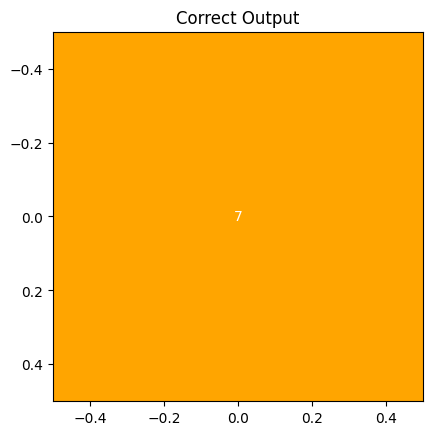

Challenge 3/20 complete. Correct so far: 1/3.
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 28


Map (num_proc=2):   0%|          | 0/14 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 14 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 28
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
6,0.040700,0.094330
12,0.035900,0.088774
18,0.035300,0.075779
24,0.025700,0.067118


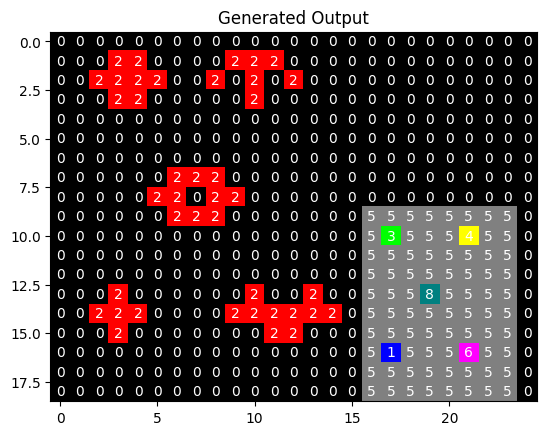

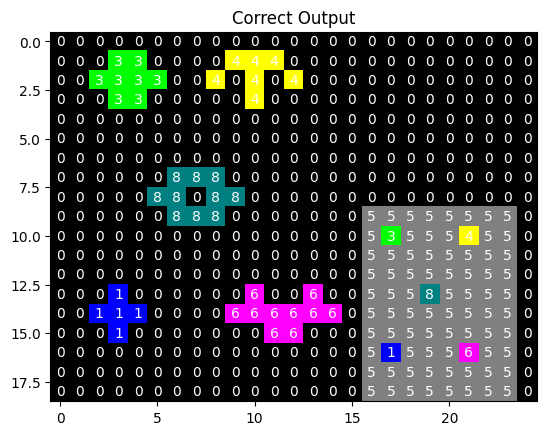

Challenge 4/20 complete. Correct so far: 1/4.
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 42


Map (num_proc=2):   0%|          | 0/21 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 21 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 42
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
9,0.390300,0.476032
18,0.355100,0.453840
27,0.322200,0.447415
36,0.326100,0.392523


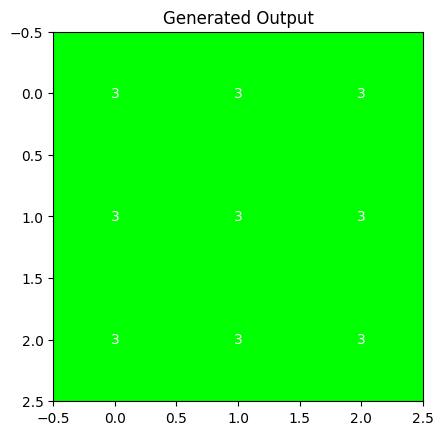

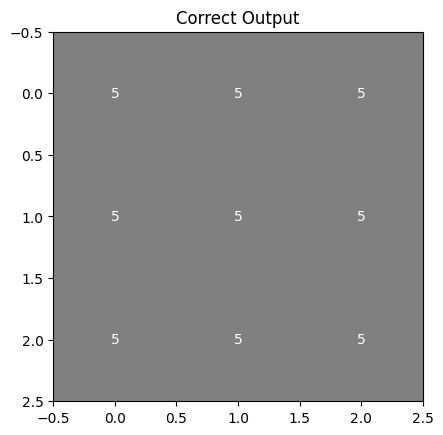

Challenge 5/20 complete. Correct so far: 1/5.
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 56


Map (num_proc=2):   0%|          | 0/28 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 28 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 56
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
12,0.069000,0.124244
24,0.067100,0.076234
36,0.050200,0.072646
48,0.049900,0.061138


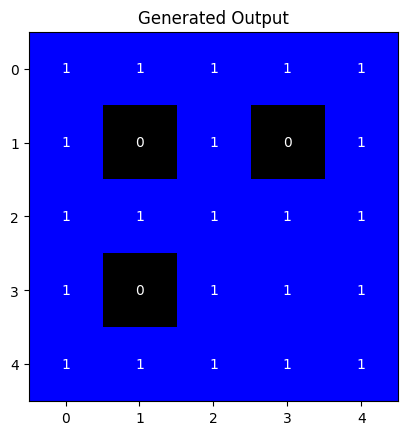

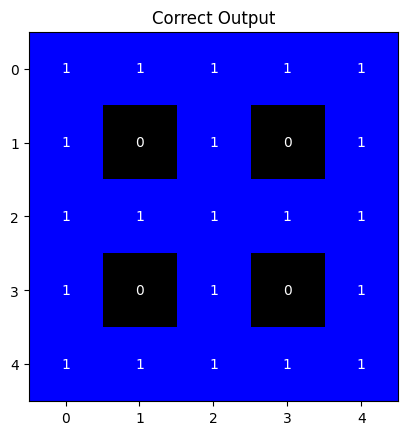

Challenge 6/20 complete. Correct so far: 1/6.
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 42


Map (num_proc=2):   0%|          | 0/21 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 21 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 42
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
9,0.069100,0.114453
18,0.052100,0.110538
27,0.041300,0.102608
36,0.035900,0.093981


Error in processing: '[' was never closed (<string>, line 1), Generated Output:  [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 2 2 2 2 2 2 0 0 0 1 0 0 3 3 3 3 3 3 0 1]
 [0 0 0 2 8 8 8 8 8 2 2 2 0 0 0 0 3 0 0 0 0 3 0 0]
 [0 0 0 2 8 8 8 8 8 8 8 2 0 0 0 0 3 0 0 6 0 3 0 0]
 [0 0 0 2 8 8 8 8 8 8 8 2 0 0 3 3 3 0 0 0 0 3 0 0]
 [0 2 2 2 8 8 8 8 8 8 8 2 0 0 3 0 0 0 0 8 0 3 0 0]
 [0 2 8 8 8 8 8 8 8 8 2 2 0 0 3 0 0 0 0 0 0 3 0 0]
 [0 2 8 8 8 8 8 8 8 8 8 8 0 0 3 0 0 0 0 0 0 3 0 0]
 [0 2 8 8 8 8 8 8 8 8 8 8 0 0 3 0 0 0 0 0 0 3 0 0]
 [0 2 8 8 8 8 8 8 8 8 8 8 0 0 3 0 0 0 0 0 0 3 0 0]
 [0 2 8 8 8 8 8 8 8 8 8 8 0 0 3 0 0 0 0 0 0 3 0 0]
 [0 2 8 8 8 8 8 8 8 8 8 8 0 0 3 0 0 0 0 0 0 3 0 0]
 [0 2 8 8 8 8 8 8 8 8 8 8 0 0 3 0 0 0 0 0 0 3 0 0]
 [0 2 8 8 8 8 8 8 8 8 8 8 0 0 3 0 0 0 0 0 0 3 0 0]
 [0 2 8 8 8 8 8 8 8 8 8 8 0 0 3 0 0 0 0 0 0 3 0 0]
 [0 2 8 8 8 8 8 8 8 8 8 8 0 0 3 0 0 0 0 0 0 3 0 0]
 [0 2 8 8 8 8 8 8 8 8 8 8 0 0 3 0 0 0 0 0 0 3 0 0]
 [0 2 8 8 8 8 8 8 8 8 8 8 0 0 3 0 0 0 0 0 0 3 0 0]
 

Map (num_proc=2):   0%|          | 0/21 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 21 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 42
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
9,0.046700,0.047138
18,0.032400,0.045386
27,0.018300,0.037545
36,0.022000,0.030926


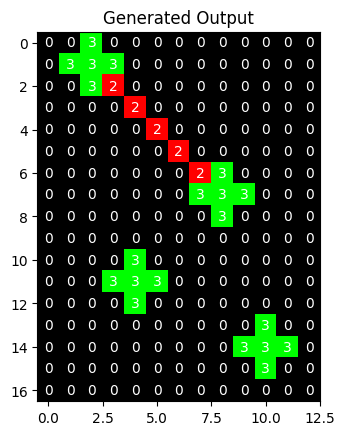

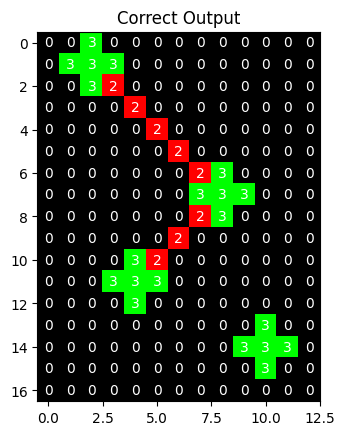

Challenge 8/20 complete. Correct so far: 1/8.
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 28


Map (num_proc=2):   0%|          | 0/14 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 14 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 28
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
6,0.093800,0.230292
12,0.074900,0.122287
18,0.050700,0.098223
24,0.042300,0.105824


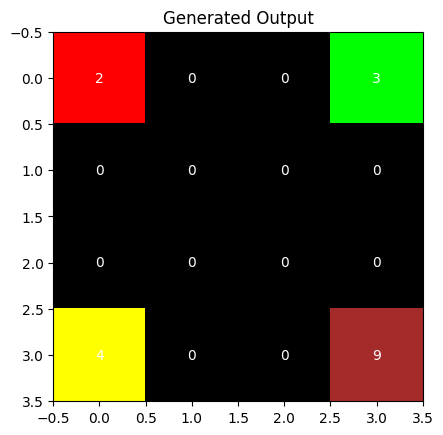

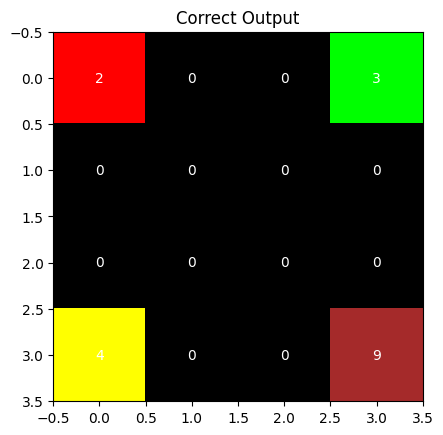

Challenge 9/20 complete. Correct so far: 2/9.
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 42


Map (num_proc=2):   0%|          | 0/21 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 21 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 42
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
9,0.035600,0.036649
18,0.022500,0.026624
27,0.014600,0.034468
36,0.017400,0.021828


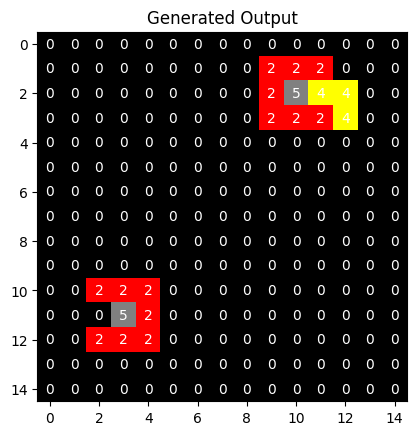

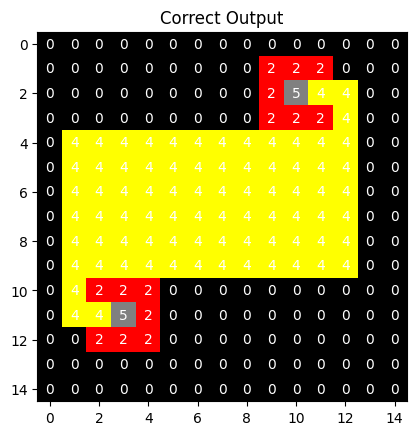

Challenge 10/20 complete. Correct so far: 2/10.
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 56


Map (num_proc=2):   0%|          | 0/28 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 28 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 56
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
12,0.071100,0.086802
24,0.051400,0.049598
36,0.038100,0.062463
48,0.038600,0.050879


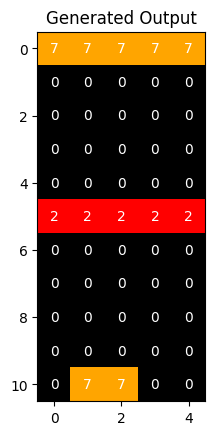

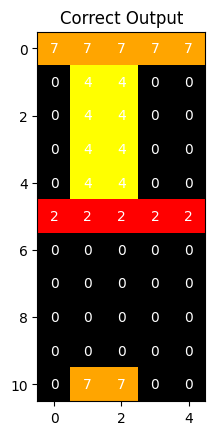

Challenge 11/20 complete. Correct so far: 2/11.
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 42


Map (num_proc=2):   0%|          | 0/21 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 21 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 42
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
9,0.166300,0.212870
18,0.115300,0.165350
27,0.108700,0.167741
36,0.087100,0.139357


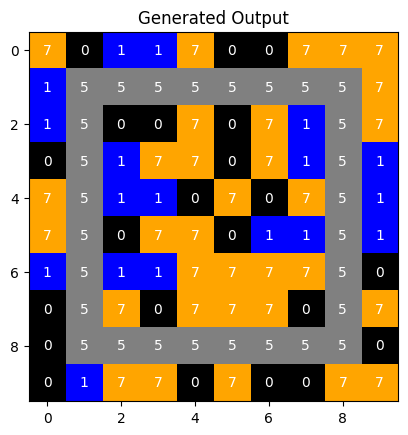

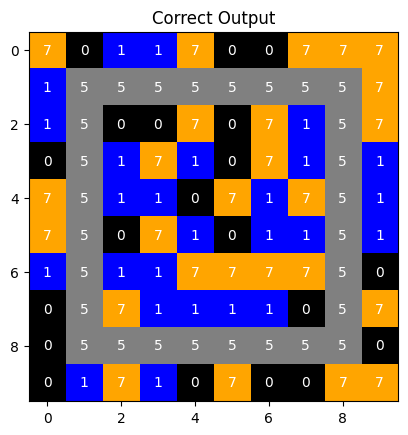

Challenge 12/20 complete. Correct so far: 2/12.
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 56


Map (num_proc=2):   0%|          | 0/28 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 28 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 56
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
12,0.049200,0.076443
24,0.048300,0.056316
36,0.033300,0.082739
48,0.038800,0.058322


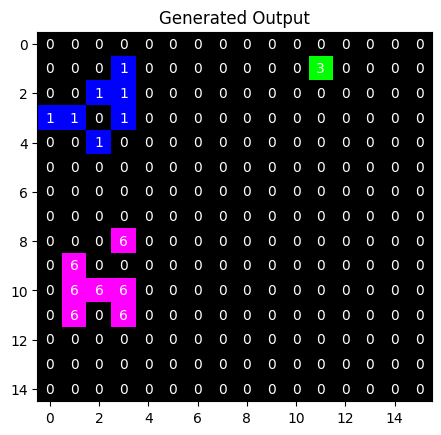

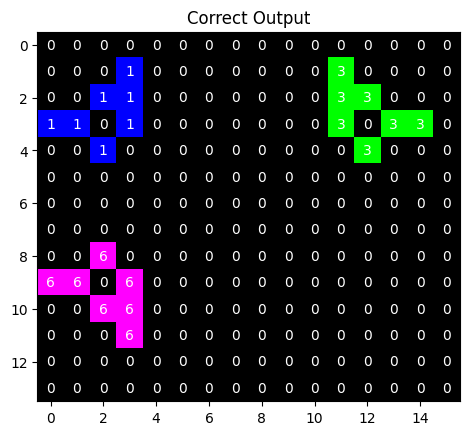

Shape mismatch: Generated (15, 16) vs Expected (14, 16)
Challenge 13/20 complete. Correct so far: 2/13.
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 42


Map (num_proc=2):   0%|          | 0/21 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 21 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 42
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
9,0.095400,0.125614
18,0.068000,0.102595
27,0.051700,0.104461
36,0.051300,0.098548


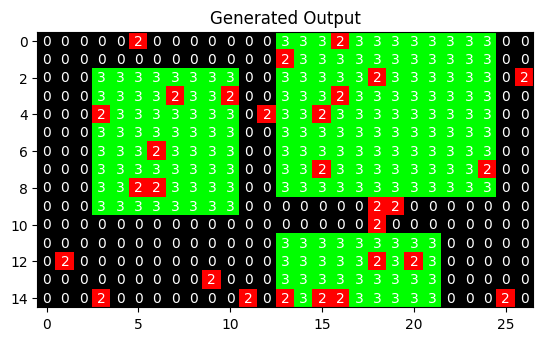

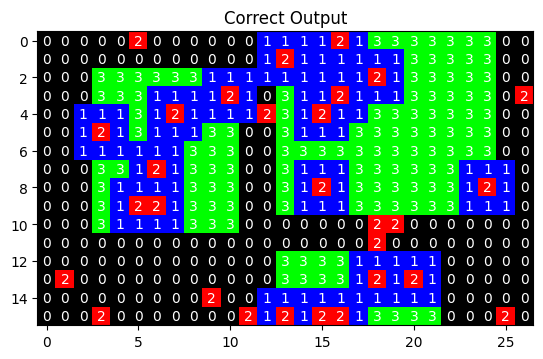

Shape mismatch: Generated (15, 27) vs Expected (16, 27)
Challenge 14/20 complete. Correct so far: 2/14.
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 28


Map (num_proc=2):   0%|          | 0/14 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 14 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 28
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
6,0.066100,0.100159
12,0.051000,0.081251
18,0.041200,0.082281
24,0.031300,0.071466


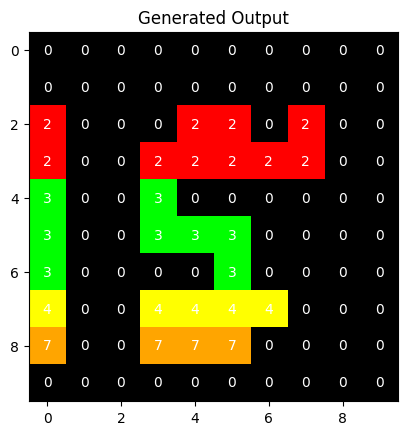

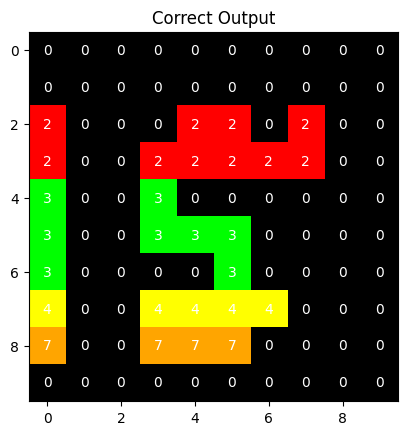

Challenge 15/20 complete. Correct so far: 3/15.
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 42


Map (num_proc=2):   0%|          | 0/21 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 21 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 42
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
9,0.054100,0.059061
18,0.042300,0.051063
27,0.024800,0.039204
36,0.022300,0.028324


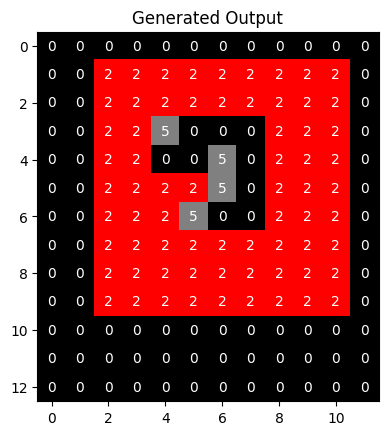

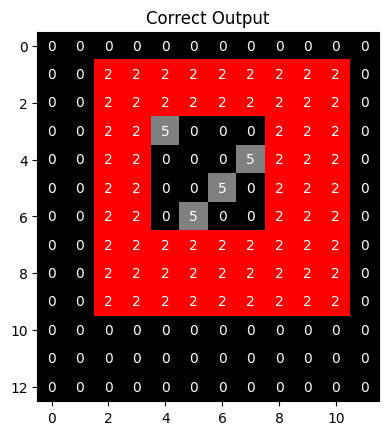

Challenge 16/20 complete. Correct so far: 3/16.
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 42


Map (num_proc=2):   0%|          | 0/21 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 21 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 42
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
9,0.056100,0.116494
18,0.038300,0.110108
27,0.019800,0.103562
36,0.020600,0.094503


Error in processing: '[' was never closed (<string>, line 1), Generated Output:  [[0 0 0 0 0 0 0 0 0 0]
 [0 6 6 6 9 9 9 0 0 0 0]
 [0 6 6 6 9 9 9 0 0 0 0]
 [0 6 6 6 9 9 9 0 0 0 0]
 [0 7 7 7 8 8 8 0 0 0 0]
 [0 7 7 7 8 8 8 0 0 0 0]
 [0 7 7 7 8 8 8 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0

Map (num_proc=2):   0%|          | 0/21 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 21 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 42
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
9,0.033200,0.035941
18,0.025000,0.030936
27,0.013200,0.022948
36,0.015600,0.018019


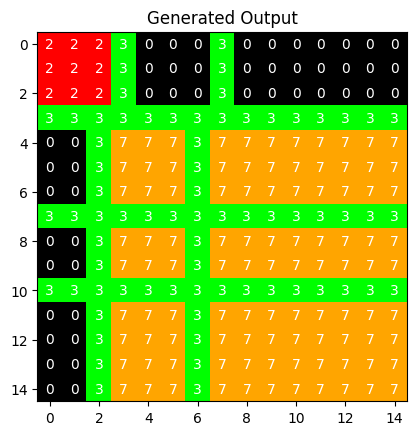

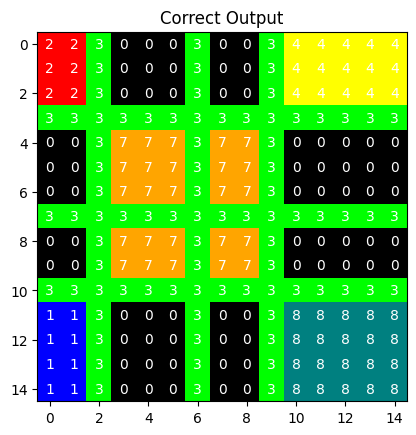

Challenge 18/20 complete. Correct so far: 3/18.
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 28


Map (num_proc=2):   0%|          | 0/14 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 14 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 28
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
6,0.067100,0.195288
12,0.063700,0.123550
18,0.051300,0.083351
24,0.042900,0.091058


Error in processing: unmatched ']' (<string>, line 1), Generated Output:  [6 0 0 4 0 0 0]
 [0 6 0 4 0 6 6]
 [6 6 6 4 0 6 0]
 [4 4 4 4 4 4 4]
 [0 0 6 4 0 0 0]
 [0 6 6 4 0 2 0]
 [0 0 0 4 0 0 0]
 [4 4 4 4 4 4 4]
 [8 8 0 4 0 0 0]
 [0 8 0 4 0 8 0]
 [8 8 8 4 0 0 0]]


Challenge 19/20 complete. Correct so far: 3/19.
==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 PCIe. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
num train steps: 42


Map (num_proc=2):   0%|          | 0/21 [00:00<?, ? examples/s]

num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 21 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 42
 "-____-"     Number of trainable parameters = 22,544,384


Step,Training Loss,Validation Loss
9,0.173600,0.198470
18,0.109600,0.145567
27,0.110800,0.144691
36,0.081200,0.113658


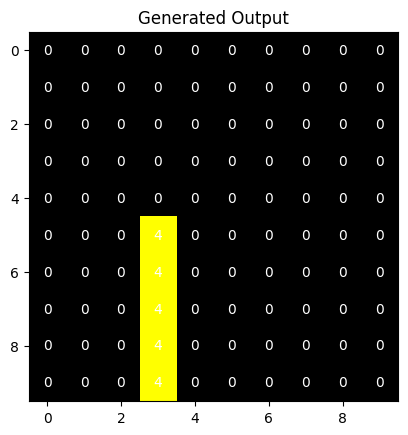

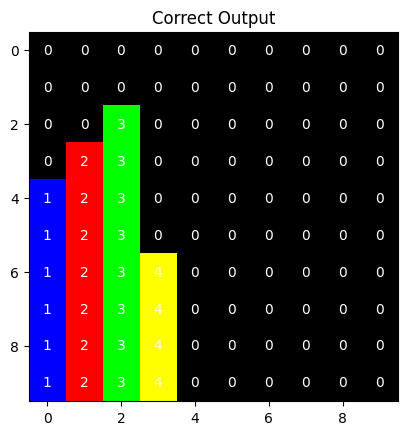

Challenge 20/20 complete. Correct so far: 3/20.
Final Tally: 3/20 challenges correct.


In [368]:
from unsloth import FastLanguageModel, is_bfloat16_supported
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from trl import SFTTrainer
from datasets import Dataset
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR

# lora_model_name = "Llama-3.2-1B-lora-model"
# lora_model_name = "Llama-3.2-3B-lora-model"
# lora_model_name = "Qwen2.5-Math-1.5B-lora-model"
# lora_model_name = "Qwen2.5-Coder-1.5B-lora-model"

gradient_accumulation_steps=1
batch_size=1
epochs=2

completions_only=False

num_tests = 20 # 83 for full MIT split

# Select the range of challenges to run
dataset_to_run = eval_dataset.select(range(num_tests))

results = []
correct_count = 0

for i, challenge in enumerate(dataset_to_run):  # Iterate directly through the dataset
    # Step 1: Filter the fine-tuning dataset for the current challenge
    challenge_file_name = challenge['file_name']

    challenge_dataset = filter_fine_tuning_dataset(fine_tuning_dataset, challenge_file_name)

    # print(challenge_dataset)
    
    # print(challenge_file_name)

    # del model, tokenizer
    
    # Step 2: Reload the model with the base LoRA
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=lora_model_name,  # Replace with your model's name
        max_seq_length=max_seq_length,
        dtype=dtype,
        load_in_4bit=load_in_4bit,
    )
    FastLanguageModel.for_inference(model)  # Enable faster inference

    # Define the Jinja template
    tokenizer.chat_template = """
    {% for message in messages %}
    {{ message.content }}{% if message.role == 'assistant' %}{{ eos_token }}{% endif %}{%- if add_generation_prompt %}{%- endif %}
    {% endfor %}
    """

    # print(f"Dataset size: {len(challenge_dataset)}")
    # print(f"Epochs: {epochs}")
    # print(f"Batch size: {batch_size}")
    # print(f"Gradient accumulation steps: {gradient_accumulation_steps}")
    # print(f"Computed num_training_steps: {num_training_steps}")
    
    def lr_lambda_specific(current_step: int, num_training_steps: int):
        if num_training_steps < 2:
            # If there are too few steps, return a constant learning rate
            return 1.0
        if current_step < num_training_steps // 2:
            return 1.0  # Constant learning rate for the first half
        else:
            progress = (current_step - num_training_steps // 2) / max(1, (num_training_steps // 2))
            return 0.5 * (1 + torch.cos(torch.tensor(progress * torch.pi)).item())

    # Step 3: Fine-tune the model on the challenge-specific dataset
    optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
    num_training_steps = len(challenge_dataset) * epochs // (batch_size * gradient_accumulation_steps)
    print(f"num train steps: {num_training_steps}")
    scheduler = LambdaLR(optimizer, lr_lambda=lambda step: lr_lambda_specific(step, num_training_steps))

    trainer = SFTTrainer(
        model=model,
        tokenizer=tokenizer,
        train_dataset=challenge_dataset,
        eval_dataset=eval_dataset.select([i]),  # Evaluate on the current challenge
        max_seq_length=max_seq_length,
        # data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
        dataset_num_proc=2,
        packing=False,
        args=TrainingArguments(
            # group_by_length=False,  # Disable grouping by length (disables shuffling)
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=1,
            gradient_accumulation_steps=gradient_accumulation_steps,
            num_train_epochs=epochs,
            logging_strategy="steps",
            logging_dir="logs",
            eval_strategy="steps",
            eval_steps=0.2,
            fp16=not is_bfloat16_supported(),
            bf16=is_bfloat16_supported(),
            logging_steps=0.1,
            optim="adamw_torch",
            seed=3407,
            output_dir="outputs",
            report_to="tensorboard",
        ),
        optimizers=(optimizer, scheduler),  # Pass the custom optimizer and scheduler
    )

    if completions_only:
        print(f"TRAINING ON COMPLETIONS ONLY!")
        # Requires commenting in the datacollator above in the trainer.
        from unsloth.chat_templates import train_on_responses_only
        trainer = train_on_responses_only(
            trainer,
            # instruction_part = "<|start_header_id|>user<|end_header_id|>\n\n",
            # response_part = "<|start_header_id|>assistant<|end_header_id|>\n\n",
            instruction_part = "Input:\n",
            response_part = "Test Output:\n",
        )
        
        tokenizer.decode(trainer.train_dataset[0]["input_ids"])
        
        space = tokenizer(" ", add_special_tokens = False).input_ids[0]
        tokenizer.decode([space if x == -100 else x for x in trainer.train_dataset[0]["labels"]])

    trainer.train()  # Fine-tune the model

    # Step 4: Run inference on the fine-tuned model
    result = solve_challenge_unsloth(challenge['messages'], model, tokenizer, visualize=True)
    results.append(result)

    # Update the correct count if the result is correct
    if result.get('is_correct', False):
        correct_count += 1

    print(f"Challenge {i+1}/{len(dataset_to_run)} complete. Correct so far: {correct_count}/{i+1}.")

# Final tally
print(f"Final Tally: {correct_count}/{len(dataset_to_run)} challenges correct.")

## 8. Submit

For submission you must create a file called 'submission.json' which should have the format as explained [here](www.kaggle.com/competitions/arc-prize-2024/overview/evaluation)

`
{"00576224": [{"attempt_1": [[0, 0], [0, 0]], "attempt_2": [[0, 0], [0, 0]]}],
 "009d5c81": [{"attempt_1": [[0, 0], [0, 0]], "attempt_2": [[0, 0], [0, 0]]}],
 "12997ef3": [{"attempt_1": [[0, 0], [0, 0]], "attempt_2": [[0, 0], [0, 0]]},
              {"attempt_1": [[0, 0], [0, 0]], "attempt_2": [[0, 0], [0, 0]]}],
 ...
}
`

In [ ]:
# print(dataset.select(range(dataset_range))[1])

In [152]:
solution_dict = {}

for i, task in enumerate(dataset.select(range(dataset_range))):
    file_name = task['file_name']

    gen_solution = task["generated_solution"]
    # For now we only do one attempt
    solution_dict[file_name] = [
        {
            "attempt_1": gen_solution,
            "attempt_2": [[0, 0], [0, 0]]
        }
    ]

# Recombining the solutions for split files
combined_solution_dict = {}
combined_files = {}

for file_name, attempts in solution_dict.items():
    base_name = file_name.split('_')[0]
    if base_name not in combined_solution_dict:
        combined_solution_dict[base_name] = []
        combined_files[base_name] = []
    combined_solution_dict[base_name].extend(attempts)
    if '_' in file_name:
        combined_files[base_name].append(file_name)
        
# Printing which file names have been combined
print("Files that have been combined:")
for base_name, files in combined_files.items():
    if files:  # Print only if there are files that were combined
        print(f"{base_name}: {', '.join(files)}")

# We still need to fill in dummy solutions for the tasks we did not consider to make a valid submission:
# Load the sample submission file
if kaggle:
    with open('/kaggle/input/arc-prize-2024/sample_submission.json') as f:
        sample_submission = json.load(f)
else:
    with open('sample_submission.json') as f:
        sample_submission = json.load(f)

# Fill in all entries that are still missing from the sample_submission file
for key, value in sample_submission.items():
    if key not in combined_solution_dict:
        combined_solution_dict[key] = value

# Create submission
with open("submission.json", "w") as json_file:
    json.dump(combined_solution_dict, json_file) 

NameError: name 'dataset_range' is not defined